<a href="https://colab.research.google.com/github/Vecheslav-Eremeev/sklearn_projects/blob/main/Titanic_Voting_Classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Imports

In [ ]:
import warnings
warnings.filterwarnings('ignore')

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import LinearSVC, SVC
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier, AdaBoostClassifier
from sklearn.ensemble import ExtraTreesClassifier, GradientBoostingClassifier, HistGradientBoostingClassifier
from sklearn.ensemble import VotingClassifier

from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

from sklearn.model_selection import train_test_split
from sklearn.inspection import permutation_importance
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import Normalizer

Load Data

In [ ]:
data = sns.load_dataset('titanic')

Data preparation

In [ ]:
drop_keys = 'survived class who adult_male deck embark_town alive'.split()

In [ ]:
X = data.drop(drop_keys, axis=1)
y = data.survived

In [ ]:
X.embarked = X.embarked.fillna(X.embarked.mode()[0])
X.age = X.age.fillna(X.age.mean())
X.alone = X.alone.astype(int)
X['family'] = X.sibsp + X.parch
X.age = pd.cut(X.age, bins=8, labels=False)
X.fare = pd.qcut(X.fare, 4, labels=False)
X = pd.get_dummies(X, drop_first=True)
X.sample(5)

,pclass,age,sibsp,parch,fare,alone,family,sex_male,embarked_Q,embarked_S
74,3,3,0,0,3,1,0,1,0,1
550,1,1,0,2,3,0,2,1,0,0
746,3,1,1,1,2,0,2,1,0,1
604,1,3,0,0,2,1,0,1,0,0
878,3,2,0,0,0,1,0,1,0,1


In [ ]:
test_size = 0.2
random_seed = 42
num_folds = 10
n_estimators = 100
scoring = 'accuracy'

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=random_seed)

Train Model

In [ ]:
models = [
          LogisticRegression(),
          LinearDiscriminantAnalysis(),
          KNeighborsClassifier(),
          DecisionTreeClassifier(),
          GaussianNB(),
          LinearSVC(),
          SVC(),
          MLPClassifier(),
          RandomForestClassifier(n_estimators=n_estimators),
          BaggingClassifier(n_estimators=n_estimators),
          AdaBoostClassifier(n_estimators=n_estimators),
          ExtraTreesClassifier(n_estimators=n_estimators),
          GradientBoostingClassifier(n_estimators=n_estimators),
          HistGradientBoostingClassifier(),
          XGBClassifier(silent=True),
          LGBMClassifier(silent=True)
]

In [ ]:
estimators = []
for model in models:
  estimators.append((model.__class__.__name__, model))

In [ ]:
def train_model(pipelines):
  model_voting = VotingClassifier(estimators=pipelines, voting='hard')
  kfold = KFold(n_splits=num_folds, random_state=random_seed, shuffle=True)
  cv_results = cross_val_score(model_voting, X_train, y_train, cv=kfold)
  print('CV results:', cv_results)
  print('Mean:', cv_results.mean())

In [ ]:
train_model(estimators)

CV results: [0.875      0.77777778 0.83098592 0.71830986 0.78873239 0.8028169
 0.87323944 0.83098592 0.81690141 0.91549296]
Mean: 0.8230242566510171


StandartScaler

In [ ]:
pipelines = []
for model in models:
  name = 'SS ' + model.__class__.__name__
  pipelines.append((name, Pipeline([('Scaler', StandardScaler()), 
                                    (model.__class__.__name__, model)])))

In [ ]:
train_model(pipelines)

CV results: [0.875      0.77777778 0.83098592 0.73239437 0.78873239 0.8028169
 0.87323944 0.83098592 0.8028169  0.91549296]
Mean: 0.8230242566510173


Noramalizer

In [ ]:
pipelines = []
for model in models:
  name = 'N ' + model.__class__.__name__
  pipelines.append((name, Pipeline([('Normalizer', Normalizer()), 
                                    (model.__class__.__name__, model)])))

In [ ]:
train_model(pipelines)

CV results: [0.83333333 0.76388889 0.83098592 0.74647887 0.74647887 0.78873239
 0.87323944 0.81690141 0.78873239 0.87323944]
Mean: 0.806201095461659


MinMaxScaler


In [ ]:
pipelines = []
for model in models:
  name = 'MinMax ' + model.__class__.__name__
  pipelines.append((name, Pipeline([('MinMaxScaler', MinMaxScaler()), 
                                    (model.__class__.__name__, model)])))

In [ ]:
train_model(pipelines)

CV results: [0.86111111 0.77777778 0.83098592 0.70422535 0.77464789 0.8028169
 0.87323944 0.83098592 0.81690141 0.88732394]
Mean: 0.8160015649452269


Permutation importances of each features

In [ ]:
model_voting = VotingClassifier(estimators, voting='hard')

In [ ]:
model_voting.fit(X_train, y_train)
model_voting.score(X_test, y_test)

0.7932960893854749

In [ ]:
result = permutation_importance(model_voting, X, y, n_repeats=10, n_jobs=-1)

In [ ]:
feature_names = X.keys()

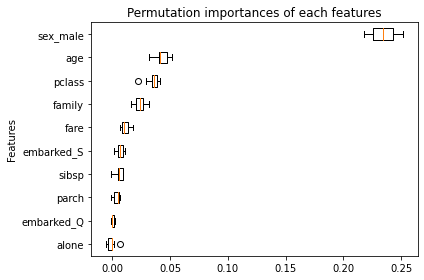

In [ ]:
sorted_idx = result.importances_mean.argsort()
plt.boxplot(result.importances[sorted_idx].T, vert=False, labels=feature_names[sorted_idx])
plt.title('Permutation importances of each features')
plt.ylabel('Features')
plt.tight_layout()
plt.show()